# Import stuff

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import borg
import torch
import time
from map2map_emu.map2map.models.d2d import *
import sys
sys.path.append("/cfs/home/ludo4644/software/")
from cosmo_py import *
import pytest
from jax import vjp

from utils.utils import *

def standard_plot(w=10,h=4,fontsize=14):
    fig = plt.figure(figsize=(w,h))
    plt.rcParams.update(plt.rcParamsDefault)
    plt.rcParams.update({'font.size': fontsize})
    plt.rcParams['font.family'] = 'DejaVu Sans'
    #plt.rc('text', usetex=True)
    return plt.gca()


# Memory layout of multi-dimensional arrays (row vs column major)
def compute_displacement(abs_pos, L, Ng, order='F'):
    # Memory layout of multi-dimensional arrays (row vs column major)
    displacement = np.zeros(np.shape(abs_pos))
    initial_pos = np.zeros(np.shape(abs_pos))
    dx = L / Ng

    for i in range(0, Ng):
        for j in range(0, Ng):
            for k in range(0, Ng):
                if order == 'F':
                    n = k + Ng * (j + Ng * i)  # column
                elif order == 'C':
                    n = i + Ng * (j + Ng * k)  # row
                
                qx = i * dx
                qy = j * dx
                qz = k * dx

                initial_pos[n] = [qx, qy, qz]

                displacement[n] = abs_pos[n] - [qx, qy, qz]
                
    return initial_pos, displacement

def check(disp,L,moved_over_bound,max_disp_1d,i,axis):
    idxsup900 = disp[:,i]>moved_over_bound
    idx100 = np.abs(disp[:,i])<max_disp_1d
    idxsubminus900 = disp[:,i]<-moved_over_bound

    sup900 = len(disp[:,i][idxsup900])
    within100 = len(disp[:,i][idx100])
    subminus900 = len(disp[:,i][idxsubminus900])

    print(f'Disp in {axis[i]} direction under -{moved_over_bound} Mpc/h is = ', subminus900)
    print(f'|Disp| in {axis[i]} direction under {max_disp_1d} Mpc/h is = ', within100)
    print(f'Disp in {axis[i]} direction over {moved_over_bound} Mpc/h is = ', sup900)
    print('These add up to: ', subminus900+within100+sup900)
    print('\n')
    
    assert subminus900+within100+sup900 == len(disp[:,i])
    
    return idxsup900, idxsubminus900
    
def correct_displacement_over_periodic_boundaries(disp,L,max_disp_1d=100):
    # Need to correct for positions moving over the periodic boundary

    axis = ['x','y','z']
    moved_over_bound = L - max_disp_1d
    
    for i in [0,1,2]:

        print(f'Before correcting {axis[i]} direction: ')
        print('len(disp[:,i]) = ',len(disp[:,i]))

        idxsup900, idxsubminus900 = check(disp,L,moved_over_bound,max_disp_1d,i,axis)

        # Correct positions
        disp[:,i][idxsup900] -= L
        disp[:,i][idxsubminus900] += L

        print(f'After correcting {axis[i]} direction: ')
        _, _ = check(disp,L,moved_over_bound,max_disp_1d,i,axis)

        assert np.amin(disp[:,i]) >= -max_disp_1d and np.amax(disp[:,i]) <= max_disp_1d
        
    return disp
    
def test_correct_pos(pos,pos_reshaped):
    # The first particle starts at 0,0,0
    # The second particle starts at 0,0,dx
    # The thrid part starts at 0,0,2*dx etc
    tol = 1e-15
    for i in range(0,10):
        assert np.sum(pos[i,:] - pos_reshaped[:,0,0,i]) < tol
        
import numpy as np
from scipy.special import hyp2f1

def dis(x, undo=False, z=0.0, dis_std=6.0, **kwargs):
    dis_norm = dis_std * D(z)  # [Mpc/h]

    if not undo:
        dis_norm = 1 / dis_norm

    x *= dis_norm
    
def vel(x, undo=False, z=0.0, dis_std=6.0, **kwargs):
    vel_norm = dis_std * D(z) * H(z) * f(z) / (1 + z)  # [km/s]

    if not undo:
        vel_norm = 1 / vel_norm

    x *= vel_norm


def D(z, Om=0.31):
    """linear growth function for flat LambdaCDM, normalized to 1 at redshift zero
    """
    OL = 1 - Om
    a = 1 / (1+z)
    return a * hyp2f1(1, 1/3, 11/6, - OL * a**3 / Om) \
             / hyp2f1(1, 1/3, 11/6, - OL / Om)

def f(z, Om=0.31):
    """linear growth rate for flat LambdaCDM
    """
    OL = 1 - Om
    a = 1 / (1+z)
    aa3 = OL * a**3 / Om
    return 1 - 6/11*aa3 * hyp2f1(2, 4/3, 17/6, -aa3) \
                        / hyp2f1(1, 1/3, 11/6, -aa3)

def H(z, Om=0.31):
    """Hubble in [h km/s/Mpc] for flat LambdaCDM
    """
    OL = 1 - Om
    a = 1 / (1+z)
    return 100 * np.sqrt(Om / a**3 + OL)

In [65]:
class emulator(borg.forward.BaseForwardModel): 
    # Constructor
    def __init__(self, box, prev_module, NN, Om):
        super().__init__(box, box)
        self.prev_module = prev_module
        self.NN = NN
        self.box = box
        self.Om = Om

    # IO "preferences"
    def getPreferredInput(self):
        return borg.forward.PREFERRED_REAL

    def getPreferredOutput(self):
        return borg.forward.PREFERRED_REAL

    # Forward part
    def forwardModel_v2_impl(self, input_array):
        # Extract particle positions
        pos = np.zeros((self.prev_module.getNumberOfParticles(), 3)) #output shape: (N^3, 3)
        self.prev_module.getParticlePositions(pos)

        # Step 1 - find displacements
        q, disp = compute_displacement(pos,self.box.L[0], self.box.N[0], order='F') #output shapes: (N^3, 3)
        
        # Step 2 - correct for particles that moved over the periodic boundary
        disp_temp = correct_displacement_over_periodic_boundaries(disp,L=self.box.L[0],max_disp_1d=100)
        
        # Step 3 - reshaping initial pos and displacement
        # not sure why order='C' is working here... not sure if it matters... could change it below
        q_reshaped = np.reshape(q.T, (3,self.box.N[0],self.box.N[0],self.box.N[0]), order='C') #output shape: (3, N, N, N)
        dis_in = np.reshape(disp_temp.T, (3,self.box.N[0],self.box.N[0],self.box.N[0]), order='C') #output shape: (3, N, N, N)
        
        # Step 4 - normalize
        print('dis_in[:,0,0,0] = ',dis_in[:,0,0,0])
        dis(dis_in)
        print('dis_in[:,0,0,0] = ',dis_in[:,0,0,0])
        
        # Step 5 - padding to (3,N+48*2,N+48*2,N+48*2)
        print('in_pad shape = ',dis_in.shape)
        dis_in_padded, self.ag_pad = vjp(self.padding, dis_in) #output shape: (3, N+96, N+96, N+96)
        print('out_pad shape = ',np.shape(np.asarray(dis_in_padded)))
        
        # Step 6 - turn into a pytorch tensor (unsquueze because batch = 1)
        self.x = torch.unsqueeze(torch.tensor(np.asarray(dis_in_padded),dtype=torch.float32, requires_grad=True),dim=0) #output shape: (1, 3, N+96, N+96, N+96)
        
        # Step 7 - Pipe through emulator
        self.y = self.NN(self.x,self.Om) #output shape: (1, 3, N, N, N)
        
        # Step 8 - N-body sim displacement 
        dis_out = torch.squeeze(self.y).detach().numpy() #output shape: (3, N, N, N)
        
        # Step 9 - undo the normalization
        print('dis_out[:,0,0,0] = ',dis_out[:,0,0,0])
        dis(dis_out,undo=True)
        print('dis_out[:,0,0,0] = ',dis_out[:,0,0,0])
        
        # Step 10 - convert displacement into positions
        pos = dis_out + q_reshaped
        
        # Step 11 - make sure everything within the box
        pos[pos>self.box.L[0]] -= self.box.L[0]
        pos[pos<0] += self.box.L[0]
        
        # Step 12 - reshape positions 
        print('step12, inshape = ',pos.shape)
        self.pos_out = pos.reshape(3,self.box.N[0]**3,order='C').T #output shape: (N^3, 3)
        print('step12, outshape = ',self.pos_out.shape)
        
    def getDensityFinal_impl(self, output_array):
        output_array[:], self.cic_grad = vjp(lambda x, y, z: jax_cic(x, y, z, *self.box.N + self.box.L),
                                             self.pos_out[:, 0],
                                             self.pos_out[:, 1], 
                                             self.pos_out[:, 2])
        
    # Adjoint part
    def adjointModel_v2_impl(self, input_ag):
        global ag_padded
        # input_ag is the ag of a over-density field
        
        # reverse getDensityFinal
        ag = np.asarray(self.cic_grad(input_ag))
        
        # reverse step 11
        ag = np.reshape(ag.T, (3,self.box.N[0],self.box.N[0],self.box.N[0]), order='C')

        print('ag_pos_out.shape = ',ag.shape)
        
        # reverse step 9
        print('ag_pos_out[:,0,0,0] = ',ag[:,0,0,0])
        dis(ag,undo=False)
        print('ag_pos_out[:,0,0,0] = ',ag[:,0,0,0])
        
        # reverse step 8
        ag = torch.unsqueeze(torch.tensor(ag,dtype=torch.float32),dim=0)
        print('ag_dis_out.shape = ',ag.shape)
        
        # reverse step 7
        ag = torch.autograd.grad(self.y, self.x, grad_outputs=ag)[0] 
        print('ag from NN shape = ',ag.shape)
        
         # reverse step 6
        ag = torch.squeeze(ag).detach().numpy()
        print('ag from NN shape = ',ag.shape)
        
        # reverse step 5
        ag = np.asarray(self.ag_pad(ag))[0] #not sure why adjoint outputs shape (1,3,128,128,128)
        print('ag_padded = ',ag.shape)

        # reverse step 4
        print('ag_padded[:,0,0,0] = ',ag[:,0,0,0])
        dis(ag,undo=True)
        print('ag_padded[:,0,0,0] = ',ag[:,0,0,0])
        
        # reverse step 3
        self.ag_pos = ag.reshape(3,self.box.N[0]**3,order='C').T
        print('self.ag_pos shape = ',self.ag_pos.shape)

        # save
        self.prev_module.adjointModelParticles(ag_pos=np.array(self.ag_pos, dtype=np.float64), ag_vel=np.zeros_like(self.ag_pos, dtype=np.float64))

    def getAdjointModel(self, output_ag):
        # TOASK: what to put here?
        output_ag[:] = 0 #self.ag_pos 
        
    def padding(self,x):
        return jnp.pad(x,((0,0),(48,48),(48,48),(48,48)),'wrap')
    

### Run forward model

In [66]:
# Initialize some default cosmology
cosmo = borg.cosmo.CosmologicalParameters()
print(cosmo)

L = 1000//4 #boxsize in Mpc/h
Nt = 512//4 #number of part^(1/3)

<CosmologicalParameters: omega_r=0, omega_k=0, omega_m=0.3, omega_b=0.049, omega_q=0.7, w=-1, n_s=1, fnl=0, wprime=0, sigma8=0.8, h=0.8, sum_mnu=0 eV, As=2.3e-09>


In [67]:
np.random.seed(42)
N_v = [Nt,Nt,Nt]
wn_field=np.random.randn(*N_v)
#delta_m, emu_delta_m = test_BORG(L,Nt,wn_field=np.random.randn(*N_v))

In [68]:
#def test_BORG(L,Nt,wn_field=[]):
global step_id
chain = 0 

# setup the box
bb = borg.forward.BoxModel()
bb.L = L,L,L
bb.N = Nt,Nt,Nt

# Initialize some default cosmology
cosmo = borg.cosmo.CosmologicalParameters()

# Fiducial scale factor to express initial conditions
z_start = 69
a0 = 1
nsteps = 20

chain = borg.forward.ChainForwardModel(bb)

# Add fluctuations and transfer
chain.addModel(borg.forward.models.Primordial(bb, a0)) # Add primordial fluctuations    
chain.addModel(borg.forward.models.EisensteinHu(bb)) # Add E&Hu transfer function

# Run LPT model from a=0.0 to af. The ai=a0 is the scale factor at which the IC are expressed
lpt = borg.forward.models.BorgLpt(bb, bb, ai=a0, af=1.0)    
chain.addModel(lpt)

# Set cosmology
chain.setCosmoParams(cosmo)

# Generate white noise: it has to be scaled by 1/N**(3./2) to be one in Fourier
ic = np.fft.rfftn(wn_field/np.sqrt(Nt**3))
assert np.std(ic) == pytest.approx(1, rel=1e-3)

delta_m = np.zeros((Nt,Nt,Nt))

# RUN!
chain.forwardModel_v2(ic)

# Get density 
chain.getDensityFinal(delta_m)

# Get pos and vel
pos = np.zeros((lpt.getNumberOfParticles(),3))
lpt.getParticlePositions(pos)

vel = np.zeros((lpt.getNumberOfParticles(),3))
lpt.getParticleVelocities(vel)

# ------------------------- Update model with emulator ----------------------------------------
emu_delta_m = np.zeros(bb.N)

# Load weights
f = '/cfs/home/ludo4644/ML4BORG/map2map_emu/map2map/weights/d2d_weights.pt'
emu_weights = torch.load(f,map_location=torch.device('cpu'))

# Initialize model
model = StyledVNet(1,3,3)
model.load_state_dict(emu_weights['model'])
#print('The emulator model has the layers: ', model.eval())

# Extract omega as style param
Om = torch.tensor([cosmo.omega_m]) # style parameter
# from emulator hacking:
Om -= torch.tensor([0.3])
Om *= torch.tensor([5.0])

# Create module in BORG chain
emu = emulator(bb, lpt, model, Om)
emu.forwardModel_v2(delta_m)
emu.getDensityFinal(emu_delta_m)
# ---------------------------------------------------------------------------------------------

"""
# test adjoint
ag = np.random.uniform(size=bb.N)
genet.adjointModel_v2(ag)
ag_genet = np.zeros(box.N)
genet.getAdjointModel(ag_genet)
"""
#return delta_m, emu_delta_m

[STD    ] |     ___________                              
[STD    ] |    /-/_"/-/_/-/|     __________________________ 
[STD    ] |   /"-/-_"/-_//||                BORG3 model
[STD    ] |  /__________/|/|     (c) Jens Jasche 2012 - 2019
[STD    ] |  |"|_'='-]:+|/||        Guilhem Lavaux 2014 - 2019
[STD    ] |  |-+-|.|_'-"||//     __________________________ 
[STD    ] |  |[".[:!+-'=|//     
[STD    ] |  |='!+|-:]|-|/       
[STD    ] |   ----------         
[STD    ] | 
[STD    ] | Please acknowledge the following papers:
[STD    ] |   - Jasche & Lavaux (A&A, 2019, arXiv 1806.11117)
[STD    ] |   - Jasche & Wandelt (MNRAS, 2012, arXiv 1203.3639)
[STD    ] |   - Jasche & Kitaura (MNRAS, 2010, arXiv 0911.2496)
[STD    ] |   - Lavaux, Jasche & Leclercq (arXiV 1909.06396)
[STD    ] |   - And relevant papers depending on the used sub-module/contribution
[STD    ] | 

[STD    ] | This is BORG version 4937f8d11f4a7cf4e7989c6ad37d145e62d7adaf
Before correcting x direction: 
len(disp[:,i]) =  20

'\n# test adjoint\nag = np.random.uniform(size=bb.N)\ngenet.adjointModel_v2(ag)\nag_genet = np.zeros(box.N)\ngenet.getAdjointModel(ag_genet)\n'

In [69]:
%matplotlib inline

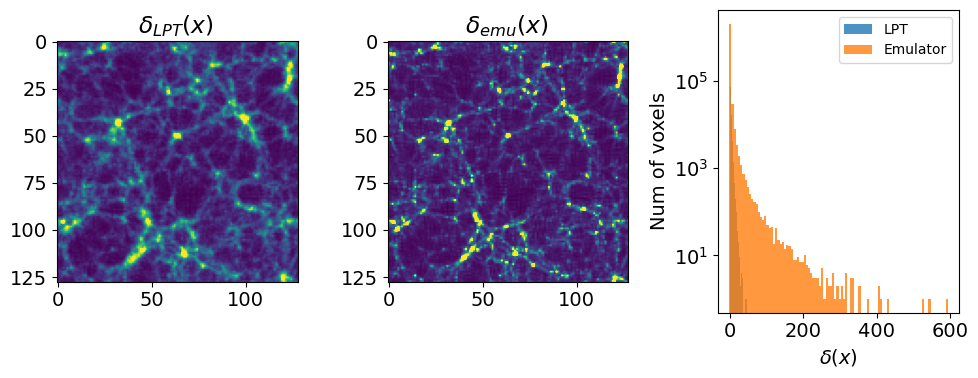

In [71]:
standard_plot(h=4)

plt.subplot(1,3,1)
plt.imshow(np.sum(delta_m[:,:,:10],axis=-1),vmax=50)
plt.title('$\delta_{LPT}(x)$ ')
plt.subplot(1,3,2)
plt.imshow(np.sum(emu_delta_m[:,:,:10]-1,axis=-1),vmax=50)
plt.title('$\delta_{emu}(x)$ ')
plt.tight_layout()
plt.subplot(1,3,3)
plt.hist(delta_m.flatten(),bins=100,label='LPT',alpha=0.8)
plt.hist((emu_delta_m-1).flatten(),bins=100,label='Emulator',alpha=0.8)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\delta(x)$')
plt.ylabel('Num of voxels')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### Test adjoint

In [8]:
# ------------------------- Update model with emulator ----------------------------------------
emu_delta_m = np.zeros(bb.N)

# Load weights
f = '/cfs/home/ludo4644/ML4BORG/map2map_emu/map2map/weights/d2d_weights.pt'
emu_weights = torch.load(f,map_location=torch.device('cpu'))

# Initialize model
model = StyledVNet(1,3,3)
model.load_state_dict(emu_weights['model'])
#print('The emulator model has the layers: ', model.eval())

# Extract omega as style param
Om = torch.tensor([cosmo.omega_m]) # style parameter
# from emulator hacking:
Om -= torch.tensor([0.3])
Om *= torch.tensor([5.0])

# Create module in BORG chain
emu = emulator(bb, lpt, model, Om)
emu.forwardModel_v2(delta_m)
emu.getDensityFinal(emu_delta_m)
# ---------------------------------------------------------------------------------------------

Before correcting x direction: 
len(disp[:,i]) =  2097152
Disp in x direction under -150.0 Mpc/h is =  9133
|Disp| in x direction under 100 Mpc/h is =  2056112
Disp in x direction over 150.0 Mpc/h is =  31907
These add up to:  2097152


After correcting x direction: 
Disp in x direction under -150.0 Mpc/h is =  0
|Disp| in x direction under 100 Mpc/h is =  2097152
Disp in x direction over 150.0 Mpc/h is =  0
These add up to:  2097152


Before correcting y direction: 
len(disp[:,i]) =  2097152
Disp in y direction under -150.0 Mpc/h is =  6851
|Disp| in y direction under 100 Mpc/h is =  2059141
Disp in y direction over 150.0 Mpc/h is =  31160
These add up to:  2097152


After correcting y direction: 
Disp in y direction under -150.0 Mpc/h is =  0
|Disp| in y direction under 100 Mpc/h is =  2097152
Disp in y direction over 150.0 Mpc/h is =  0
These add up to:  2097152


Before correcting z direction: 
len(disp[:,i]) =  2097152
Disp in z direction under -150.0 Mpc/h is =  14781
|Disp| in z

In [72]:
# test adjoint
ag = np.random.uniform(size=bb.N)
emu.adjointModel_v2(ag)

ag_pos_out.shape =  (3, 128, 128, 128)
ag_pos_out[:,0,0,0] =  [ 0.15595293 -0.13838054 -0.2891013 ]
ag_pos_out[:,0,0,0] =  [ 0.02599216 -0.02306342 -0.04818355]
ag_dis_out.shape =  torch.Size([1, 3, 128, 128, 128])
ag from NN shape =  torch.Size([1, 3, 224, 224, 224])
ag from NN shape =  (3, 224, 224, 224)
ag_padded =  (3, 128, 128, 128)
ag_padded[:,0,0,0] =  [ 0.00019388  0.01069927 -0.01952273]
ag_padded[:,0,0,0] =  [ 0.00116326  0.06419562 -0.11713637]
self.ag_pos shape =  (2097152, 3)


In [10]:
ag_emu = np.zeros(bb.N)
emu.getAdjointModel(ag_emu)

# Tests

## Density test (Jens_cic vs jax_cic vs BORG_getDensity)

In [6]:
from jax import vjp
import jax.numpy as jnp
import numpy as np
from utils.utils import *

In [17]:
# Note need to flip positions here...! # Jens implementation .... 
delta_m2 = density(pos[:,2],pos[:,1],pos[:,0],L,N)
delta_m2.shape

cell_len =  1.953125


(128, 128, 128)

In [15]:
delta_m3, cic_grad = vjp(lambda x, y, z: jax_cic(x, y, z, N, N, N, L, L, L), pos[:, 0], pos[:, 1], pos[:, 2])

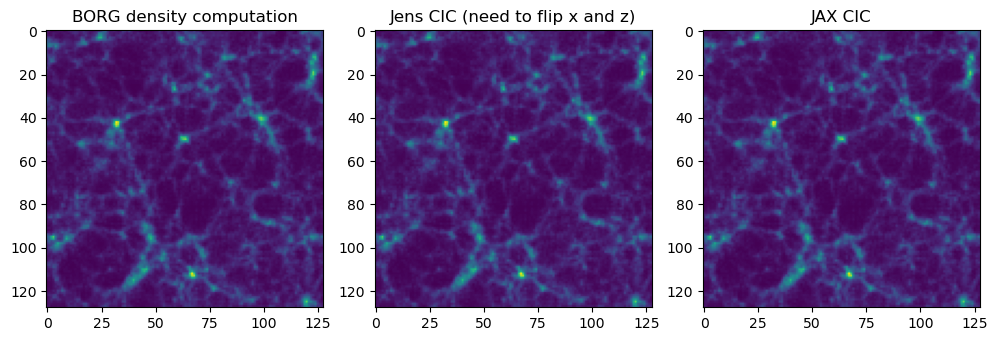

In [21]:
standard_plot(h=8,fontsize=10)

plt.subplot(1,3,1)
plt.imshow(np.sum(delta_m[:,:,:10],axis=-1))
plt.title('BORG density computation')
plt.subplot(1,3,2)
plt.imshow(np.sum(delta_m2[:,:,:10],axis=-1))
plt.title('Jens CIC (need to flip x and z)')
plt.subplot(1,3,3)
plt.imshow(np.sum(delta_m3[:,:,:10],axis=-1))
plt.title('JAX CIC')
plt.tight_layout()
plt.show()

## Gradient test

In [76]:
from torch import nn
from torch.nn import functional as F
from torchsummary import summary

class ToyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()
        self.block1conv1 = nn.Conv3d(1, 32, 3)
        self.block1conv2 = nn.Conv3d(32, 1, 3)
        self.maxpool = nn.MaxPool3d(2)

    def forward(self, x):
        x = self.relu(self.block1conv1(x))
        x = self.relu(self.block1conv2(x))
        x = self.maxpool(x)

        return x

model = ToyResNet()
#summary(model.cuda(),(1,36,36,36))

In [105]:
np.random.seed(42)
in_field = np.random.random((1,16,16,16))
in_true = np.copy(in_field) + np.random.random((1,16,16,16))*0.01

def padding(x):
        return jnp.pad(x,((0,0),(10,10),(10,10),(10,10)),'wrap')

def forward(f,grad=False):
    # Normalize field
    f = f/10
    
    # Add 
    f += 10
    
    # Pad field
    f_out, ag_pad = vjp(padding, f)
    
    # Pipe through NN
    x = torch.unsqueeze(torch.tensor(np.asarray(f_out),dtype=torch.float32, requires_grad=grad),dim=0)
    
    y = model(x)
    out = torch.squeeze(y).detach().numpy()
    
    # Unnormalize field
    out *= 10
    
    return x, y, out, ag_pad
    
def loss(out,out_true):
    return jnp.sum((out-out_true)**2)

# Run forward for truth and a field close to the truth
_, y, out_true, _ = forward(in_true)
x, y, out, ag_pad = forward(in_field,grad=True)

# Get likelihood/loss
L, agL = vjp(loss,out,out_true)
print(L)

0.0020001223


In [106]:
def finite_diff(in_field,out_true,eps,x0,x1,x2,x3):
    # Copy field
    in_field_epsilon = np.copy(in_field)
    
    # Perturb
    in_field_epsilon[x0,x1,x2,x3] = in_field[x0,x1,x2,x3] + eps
    # Compute likelihood
    _, _, out_eps, _ = forward(in_field_epsilon)
    L_eps = loss(out_eps,out_true)
    #print('L = ',L_eps)
    
    # Re-perturb
    in_field_epsilon[x0,x1,x2,x3] = in_field[x0,x1,x2,x3] - eps
    # Recompute
    _, _, out_eps, _ = forward(in_field_epsilon)
    L_eps -= loss(out_eps,out_true)
    #print('L = ',L_eps)
    
    # Centered numerical gradient
    QQ = L_eps / (2.0*eps )
    
    return QQ

In [120]:
from tqdm import tqdm

# Finite diff
eps_v = [0.1,0.01,0.001,0.0001]
fd_v = []
for eps in eps_v:
    fdtemp = []
    for i in tqdm(range(16)):
        coords = [0,0,0,i]
        fd = finite_diff(in_field,out_true,eps,*coords)
        fdtemp.append(fd)
    fd_v.append(fdtemp)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


In [123]:
# Analytical: get everything for full field directly

ag = torch.unsqueeze(torch.unsqueeze(torch.tensor(np.asarray(agL(1.))[0]),dim=0),dim=0)
ag /= 10
ag = torch.autograd.grad(y, x, grad_outputs=ag, retain_graph=True)[0] 
ag = ag_pad(torch.squeeze(ag,dim=0).detach().numpy())
ag = np.squeeze(ag)
ag *= 10
analytical_grad = []
for i in tqdm(range(16)):
    analytical_grad.append(ag[0,0,i])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 216480.21it/s]


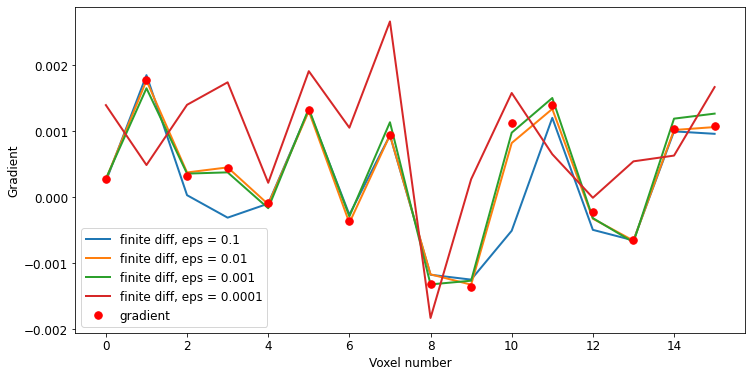

In [127]:
# Plot diff btw gradient and finite difference 

%matplotlib inline
standard_plot(w=12,h=6,fontsize=12)
for i,fd in enumerate(fd_v):
    plt.plot(fd,'-',lw=2,label=f'finite diff, eps = {eps_v[i]}')
plt.plot(analytical_grad,'.',c='r',markersize=15,label='gradient')
plt.xlabel('Voxel number')
plt.ylabel('Gradient')
plt.legend()
plt.show()

## Reshaping test

In [62]:
np.random.seed(42)
N=10
resh_in = np.random.random((N**3,3))
print('Shape in = ',resh_in.shape)
print(resh_in[0:2,:])

### --------------- Forward pass: -------------------------

# Step 1
q, disp = compute_displacement(resh_in,250,10)

# Step 3 - reshaping initial pos and displacement
# not sure why order='C' is working here... not sure if it matters... could change it below
q_reshaped = np.reshape(q.T, (3,N,N,N), order='C') #output shape: (3, N, N, N)
dis_in = np.reshape(disp.T, (3,N,N,N), order='C') #output shape: (3, N, N, N)
dis_out = dis_in

# Step 10 - convert displacement into positions
pos = dis_out + q_reshaped

# Step 12 - reshape positions 
pos_out = pos.reshape(3,N**3,order='C').T #output shape: (N^3, 3)

### --------------- GO BACK: -------------------------

# reverse getDensityFinal
ag = pos_out 

# reverse step 11
ag = np.reshape(ag.T, (3,N,N,N), order='C')

# reverse step 3
ag_pos = ag.reshape(3,N**3,order='C').T
print('Shape out = ',ag_pos.shape)
print(ag_pos[0:2,:])

Shape in =  (1000, 3)
[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]]
Shape out =  (1000, 3)
[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]]


# Integrate emu-model from Drew into BORG 

In [ ]:
# Todo:
# 1. compute_displacement much faster if we store q_v and n_v = [n1,...,nN^3]